# Clustering

## k-means algorithm

Suppose we are given a dataset of $n$ points $x_1,...,x_n \in \mathbb{R}^d$. We wish to find $K$ clusters in the dataset, which in this case means minimizing the function

$$ \sum_{i=1}^n \sum_{k=1}^K \mathbb{1}_{\{c_i = k\}} \|x_i - \mu_k\|^2,$$

where $\|\cdot\|$ is the $\ell^2$-distance. The algorithm uses the coordinate ascent and consists of two steps:

1. Update cluster assignements: 
$$c_i = \text{arg}\min_k \|x_i - \mu_k\|.$$
2. Update centroids: 
$$\mu_k = \frac{\sum_{i=1}^n x_i \mathbb{1}_{\{c_i = k\}}}{\sum_{i=1}^n \mathbb{1}_{\{c_i = k\}}}.$$

## Application: dataset generated from Gaussians

As an example, we are working on the following dataset, generated from three different Gaussians:

First let us import all necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

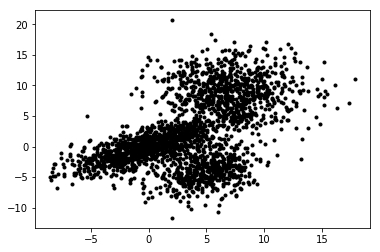

In [2]:
mean1 = np.array([0, 0])
cov1 = np.matrix([[10, 5], [5, 5]])
mean2 = np.array([7, 9])
cov2 = np.matrix([[10, 0], [0, 10]])
mean3 = np.array([5, -4])
cov3 = np.matrix([[5, 2], [2, 5]])
X = np.random.multivariate_normal(mean1, cov1, 1000)
Y = np.random.multivariate_normal(mean2, cov2, 800)
Z = np.random.multivariate_normal(mean3, cov3, 500)
X = np.concatenate((X, Y, Z))

red = np.array([1, 0, 0])
green = np.array([0, 1, 0])
blue = np.array([0, 0, 1])
COLOR_MAP = {0 : red, 1: green, 2: blue}

for n in range(X.shape[0]):
    plt.plot(X[n, 0], X[n, 1], 'ro', color='k', markersize=3)
plt.show()
K = 3 #number of clusters

Following is the code of the k-means algorithm:

In [3]:
K = 3#number of clusters

def kmeans(X, iterations=10):
    col = X.shape[1] #number of coordinates of each vector
    row = X.shape[0] #number of given vectors
    mu = np.random.rand(K, col) #initialize centroids randomly
    c = np.zeros(row) #assigments to clusters
    dist = np.zeros(K) #auxiliary vector of distances to centroids

    for i in range(iterations):
        print('Iteration number ',i + 1,' / ',iterations)
        
        ##update cluster assigments
        for n in range(row):
            for k in range(K):
                dist[k] = np.linalg.norm(X[n, :] - mu[k, :])
            c[n] = np.argmin(dist)

        ##update centroids
        for k in range(K):
            sum_k = np.zeros(col)
            n_k = 0
            for n in range(row):
                if c[n] == k:
                    sum_k += X[n, :]
                    n_k += 1
            if n_k != 0:
                mu[k, :] = sum_k/float(n_k)
            else:
                mu[k, :] = np.random.rand(col)

    return mu, c

Here is the result of running the code on the above dataset for $10$ iterations. The centroids are marked with 'X':

Iteration number  1  /  10
Iteration number  2  /  10
Iteration number  3  /  10
Iteration number  4  /  10
Iteration number  5  /  10
Iteration number  6  /  10
Iteration number  7  /  10
Iteration number  8  /  10
Iteration number  9  /  10
Iteration number  10  /  10


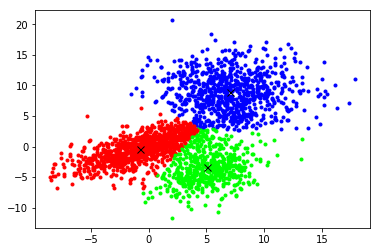

In [4]:
mu, c = kmeans(X)

# plot results
for n in range(X.shape[0]):
    plt.plot(X[n, 0], X[n, 1], 'ro', color=COLOR_MAP[c[n]], markersize=3)

for k in range(K):
    plt.plot(mu[k, 0], mu[k, 1], 'x', color='k', markersize=7)
plt.show()

## EM algorithm for Gaussian mixture model

Suppose we are given a dataset of $n$ points $x_1,...,x_n \in \mathbb{R}^d$. We wish to find $K$ 'soft' clusters in the dataset coming from $K$ gaussians, which in this case means maximizing the function
$$\sum_{i=1}^n \ln p(x_i | \pi, \mu, \Sigma),$$
where $\|\cdot\|$ is the $\ell^2$-distance and $\mu = (\mu_1,..., \mu_K)$, $\Sigma = (\Sigma_1,..., \Sigma_K)$ are respectively the means and the covariances of $K$ gaussians. Moreover $\pi = (\pi_1,..., \pi_K)$ is such that $\pi_k$ is the probability that a points belongs to the $k$-th cluster. Let $N$ denote the density function of the normal distribution. We run the following EM algorithm in order to maximize the function in the previous display. Here is a single iteration:

1. Update soft cluster assignements ($\phi_i(k)$ is intuitively the probability that point $x_i$ belongs to the $k$-th cluster): 
$$ \phi_i(k) = \frac{\pi_k N(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j N(x_i|\mu_j, \Sigma_j)}. $$

2. Update probabilities, means and covariances: 
$$ n_k = \sum_{i=1}^n \phi_i(k), $$
$$\pi_k = \frac{n_k}{n},$$
$$\mu_k = \frac{1}{n_k} \sum_{i=1}^n \phi_i(k) x_i,$$ 
$$\Sigma_k = \frac{1}{n_k} \sum_{i=1}^n \phi_i(k) (x_i - \mu_k)(x_i - \mu_k)^T.$$

## Application: dataset generated from Gaussians

Now, let us apply the expectation-maximization(EM) algorithm to the same generated dataset. Here is the implementation of the algorithm:

In [5]:
def gmm(X, iterations=10):
    col = X.shape[1] #number of coordinates of each vector
    row = X.shape[0] #number of given vectors
    mu = np.random.rand(K, col) #initialize centroids randomly
    sigma = np.zeros((K, col, col))
    phi = np.zeros((row, K)) #assigments to clusters

    ## normalized pi
    pi = np.ones(K)/float(K)

    ## make random sigmas identity
    for k in range(K):
        sigma[k, :, :] = np.identity(col)

    for i in range(iterations):
        print('Iteration number ',i + 1,' / ',iterations)
        
        ## E-step
        for n in range(row):
            sum_aux = 0
            for k in range(K):
                sum_aux += pi[k]*multivariate_normal.pdf(X[n, :], mu[k, :], sigma[k, :, :])
            for k in range(K):
                if sum_aux == 0:
                    phi[n, k] = pi[k]/float(K)
                else:
                    phi[n, k] = pi[k]*multivariate_normal.pdf(X[n, :], mu[k, :], sigma[k, :, :])/sum_aux

        ## M-step
        for k in range(K):
            n_k = 0
            mu_sum = np.zeros(col)
            sigma_sum = np.zeros((col, col))
            for n in range(row):
                n_k += phi[n, k]
                mu_sum += phi[n, k]*X[n, :]
                vec = X[n, :] - mu[k, :]
                sigma_sum += phi[n, k]*np.outer(vec, vec)
            pi[k] = float(n_k)/float(row)
            if n_k == 0:
                mu[k, :] = np.random.rand(col)
                sigma[k, :, :] = np.identity(col)
            else:
                mu[k, :] = mu_sum/float(n_k)
                sigma[k, :, :] = sigma_sum/float(n_k)

    return pi, mu, sigma, phi

Here is the result of running the code on the above dataset for 10 iterations. Depending on the values of cluster assignments appropriate 'mix' of colours is used:

Iteration number  1  /  10
Iteration number  2  /  10
Iteration number  3  /  10
Iteration number  4  /  10
Iteration number  5  /  10
Iteration number  6  /  10
Iteration number  7  /  10
Iteration number  8  /  10
Iteration number  9  /  10
Iteration number  10  /  10


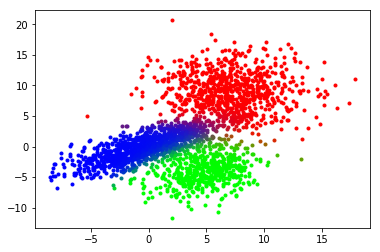

In [7]:
pi, mu, sigma, phi = gmm(X)

# plot results
for n in range(X.shape[0]):
    colour = phi[n, 0] * COLOR_MAP[0] + phi[n, 1] * COLOR_MAP[1] + phi[n, 2] * COLOR_MAP[2]
    plt.plot(X[n, 0], X[n, 1], 'ro', color=colour, markersize=3)
plt.show()